<a href="https://colab.research.google.com/github/m-azadd/Analytics-Exchange/blob/main/Biking_R_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who Bikes in New York City?
## Looking at biking in the city by gender, using the collected in the 2022 Citywide Mobility Survey

The purpose of this training is to highlight a topic of interest and demonstrate a method for working with CMS data in R.




## Loading Packages
To start, load the packages into R.

In [ ]:
# List of packages to be installed and loaded
packages <- c("dplyr", "lubridate", "ggplot2","readxl","readr","tidyverse","scales")

# Install and load the packages
lapply(packages, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

## Load CMS Data
One way to access CMS data is through the Open Data portal. You may also download the data to your system and use the corresponding file paths.

Here, we use the Person and Trip tables by reading them from Open Data:

In [ ]:
# Load the Person data from NYC Open Data
dfPerson <- read_csv("https://data.cityofnewyork.us/api/views/7qdz-u9hr/rows.csv?accessType=DOWNLOAD", show_col_types = FALSE,
  col_types = list(
    hh_id = "c",                # Household ID as character
    person_id = "c",            # Person ID as character
    school_park_amount = "n"    # School parking amount as numeric
  ))

# Load the Trip data from NYC Open Data
dfTrip <- read_csv("https://data.cityofnewyork.us/api/views/x5mc-2gmi/rows.csv?accessType=DOWNLOAD", show_col_types = FALSE,
  col_types = list(
    hh_id = "c",        # Household ID as character
    person_id = "c",    # Person ID as character
    day_id = "c"        # Day ID as character
  ))

To begin our analysis, we'll examine the gender variable in the person table to understand its distribution among participants.

It's essential to consider both the raw count of participants and their corresponding weights, especially when we are analyzing subgroups. When dealing with a small raw number of observations, it is crucial to exercise greater caution and scrutiny when interpreting the results, as small sample sizes can potentially lead to less reliable or less representative findings

In this case, we'll utilize the person_weight column, which represents the appropriate weights for each participant.

In [ ]:
dfPerson %>%
  # Filter out rows where person_weight is 0 or less
  filter(person_weight > 0) %>%
  # Group the data by gender
  group_by(gender) %>%
  # Summarize the data by calculating the count of individuals and the sum of person_weight
  summarize(
    count = n(),                             # Count the number of individuals in each gender group
    weighted_sum = sum(person_weight, na.rm = TRUE)  # Calculate the sum of person_weight for each gender group, ignoring NA values
  )

gender,count,weighted_sum
<dbl>,<int>,<dbl>
1,1547,3101551.451
2,1276,3105463.571
4,34,55416.280
5,3,2843.995
997,5,18211.011
999,101,316324.479


## Codebook

Without data lables, we cannot understand the data completely. The variables are recorded using codes in the data, and we refer to the codebook to obtain the labels for the factors.

In this step, we will use the codebook to add labels to the variables.

Download the codebook from Open Data (attachment to all 2022 tables). Then go to ***Files*** on the left panel, and click on ***Upload to session storage*** to upload it to your session.


In [ ]:
# Load the variable descriptions from the "variable_list" sheet of the Excel file
var_desc = read_excel("2022_NYC_CMS_Codebook.xlsx",
    sheet = "variable_list")

# Display the first few rows of the variable descriptions
var_desc %>%
  head()

# Load the value labels from the "value_labels" sheet of the Excel file
# Specify the column types, setting the "value" column as text
value_labels = read_excel("2022_NYC_CMS_Codebook.xlsx",
    sheet = "value_labels",
    col_types = c(
    "value" = "text"
    ))

# Display the first few rows of the value labels
value_labels %>%
  head()

sort,source,variable,is_checkbox,hh,person,day,trip,vehicle,location,data_type,description,var_logic
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,pipeline,hh_id,0,1,1,1,1,1,0,numeric,Household ID,NA
2,pipeline,sample_segment,0,1,0,0,0,0,0,integer/categorical,Sample segment,NA
3,pipeline,hh_cms_zone,0,1,0,0,0,0,0,integer/categorical,Sample segment - 2019 reinvites recoded,NA
4,pipeline,hh_cms_zone_gp,0,1,0,0,0,0,0,integer/categorical,Sample segment - grouped,NA
5,pipeline,participation_group,0,1,0,0,0,0,0,integer/categorical,Participation group,NA
6,pipeline,signup_platform,0,1,0,0,0,0,0,integer/categorical,Signup survey platform,NA


variable,value,label,logic_text
<chr>,<chr>,<chr>,<chr>
age,1,Under 5,If not hh member 1
age,2,5-15,If not hh member 1
age,3,16-17,If not hh member 1
age,4,18-24,NA
age,5,25-34,NA
age,6,35-44,NA


To use the labels for this training, we subset for the variable of interest. Here, we use gender, bike frequncy, and trip mode type variables. Start by storing the corresponding labels in labs.gender, labs.bikefreq, and labs.mode, and review the lables:

In [ ]:
labs.gender = filter(value_labels, variable == "gender")
labs.gender

labs.bikefreq = filter(value_labels, variable == "bike_freq")
labs.bikefreq

labs.mode = filter(value_labels, variable == "mode_type_nyc")
labs.mode

variable,value,label,logic_text
<chr>,<chr>,<chr>,<chr>
gender,1,Woman,NA
gender,2,Man,NA
gender,4,Non-binary,NA
gender,5,Prefer to self-describe,NA
gender,995,Missing response,NA
gender,997,Other,NA
gender,999,Prefer not to answer,NA


variable,value,label,logic_text
<chr>,<chr>,<chr>,<chr>
bike_freq,1,5 or more days a week,NA
bike_freq,2,4 days a week,NA
bike_freq,3,2-3 days a week,NA
bike_freq,4,1 day a week,NA
bike_freq,5,1-3 days a month,NA
bike_freq,6,Less than monthly,NA
bike_freq,995,Missing response,NA
bike_freq,996,Never,NA


variable,value,label,logic_text
<chr>,<chr>,<chr>,<chr>
mode_type_nyc,1,For-Hire Vehicle,NA
mode_type_nyc,2,For-Hire Vehicle TNC,NA
mode_type_nyc,3,Commuter Rail,NA
mode_type_nyc,4,Bus,NA
mode_type_nyc,5,Ferry,NA
mode_type_nyc,6,Subway,NA
mode_type_nyc,7,Vehicle,NA
mode_type_nyc,8,Bike,NA
mode_type_nyc,9,Walk,NA


For single response variables, we can convert the variable to a labeled factor. Multiple response categorical variables have to be handled differently, as shown below.

In [ ]:
# Mutate dfPerson to create factor variables for gender and bike frequency
dfPerson = dfPerson %>%
  mutate(
    gender_f = factor(                     # Create a factor variable for gender
      gender,                              # Original gender variable
      levels = labs.gender$value,          # Specify levels using values from labs.gender
      labels = labs.gender$label           # Specify labels using labels from labs.gender
    ),
    bikefreq_f = factor(                   # Create a factor variable for bike frequency
      bike_freq,                           # Original bike_freq variable
      levels = labs.bikefreq$value,        # Specify levels using values from labs.bikefreq
      labels = labs.bikefreq$label         # Specify labels using labels from labs.bikefreq
    )
  )

Let's go back to the distribution of gender in the whole dataset:

In [ ]:
dfPerson %>%
  # Filter out rows where person_weight is 0 or less
  filter(person_weight > 0) %>%
  # Group the data by both gender and the factor version of gender (gender_f)
  group_by(gender, gender_f) %>%
  # Summarize the data by calculating the count of individuals and the sum of person_weight
  summarize(
    count = n(),                                     # Count the number of individuals in each gender group
    weighted_sum = sum(person_weight, na.rm = TRUE), # Calculate the sum of person_weight for each gender group, ignoring NA values
    .groups = 'drop' )                               # Drop the grouping after summarizing

gender,gender_f,count,weighted_sum
<dbl>,<fct>,<int>,<dbl>
1,Woman,1547,3101551.451
2,Man,1276,3105463.571
4,Non-binary,34,55416.280
5,Prefer to self-describe,3,2843.995
997,Other,5,18211.011
999,Prefer not to answer,101,316324.479


Now take a look at the general biking frequncy among New Yorkers:

In [ ]:
dfPerson %>%
  # Filter out rows where person_weight is 0 or less
  filter(person_weight > 0) %>%
  # Group the data by both the original bike frequency and the factor version of bike frequency (bikefreq_f)
  group_by(bike_freq, bikefreq_f) %>%
  # Summarize the data by calculating the count of individuals and the sum of person_weight
  summarize(
    count = n(),                             # Count the number of individuals in each bike frequency group
    weighted_sum = sum(person_weight, na.rm = TRUE),  # Calculate the sum of person_weight for each bike frequency group, ignoring NA values
    .groups = 'drop'                         # Drop the grouping after summarizing
  )

bike_freq,bikefreq_f,count,weighted_sum
<dbl>,<fct>,<int>,<dbl>
1,5 or more days a week,139,330266.6
2,4 days a week,59,111964.8
3,2-3 days a week,152,332786.5
4,1 day a week,108,264577.2
5,1-3 days a month,212,522205.4
6,Less than monthly,544,1137866.7
995,Missing response,28,143877.5
996,Never,1724,3756266.0


We can also look at the distribution by creating plots:

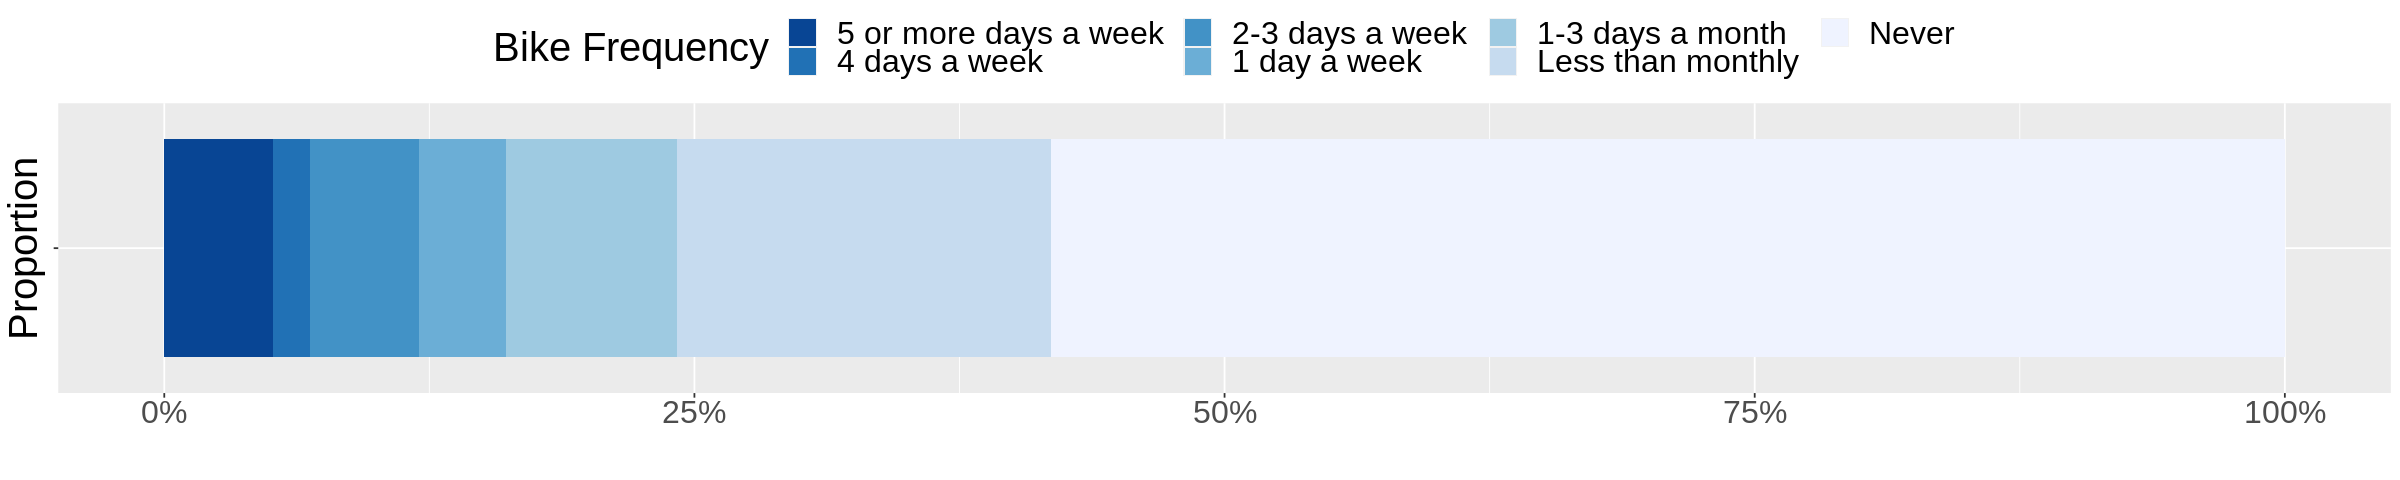

In [ ]:
# Set the plot dimensions
options(repr.plot.width = 20, repr.plot.height = 4)

dfPerson %>%
  # Filter out rows where person_weight is 0 or less and exclude 'Missing response' for bike frequency
  filter(person_weight > 0 & !bikefreq_f == "Missing response") %>%
  # Group the data by bike frequency factor
  group_by(bikefreq_f) %>%
  # Summarize the data by calculating the sum of person_weight for each bike frequency group
  summarize(weighted_sum = sum(person_weight, na.rm = TRUE)) %>%
  # Calculate the proportion of each bike frequency group
  mutate(prop = weighted_sum / sum(weighted_sum)) %>%
  # Reverse the order of the bike frequency factor levels
  mutate(bikefreq_f = forcats::fct_rev(bikefreq_f)) %>%
  # Create a bar plot
  ggplot(aes(x = prop, y = "", fill = bikefreq_f)) +
  geom_col() +  # Add bars
  labs(x = "", y = "Proportion", fill = "Bike Frequency") +  # Add axis labels and legend title
  scale_x_continuous(labels = scales::percent) +  # Format x-axis labels as percentages
  theme(text = element_text(size = 24), legend.position = "top") +  # Customize text size and legend position
  guides(fill = guide_legend(reverse = TRUE)) +  # Reverse the order of the legend
  scale_fill_brewer(palette = "Blues")  # Use a color palette from RColorBrewer

We can simplify the interpretation by collapsing the factors into fewer categories:

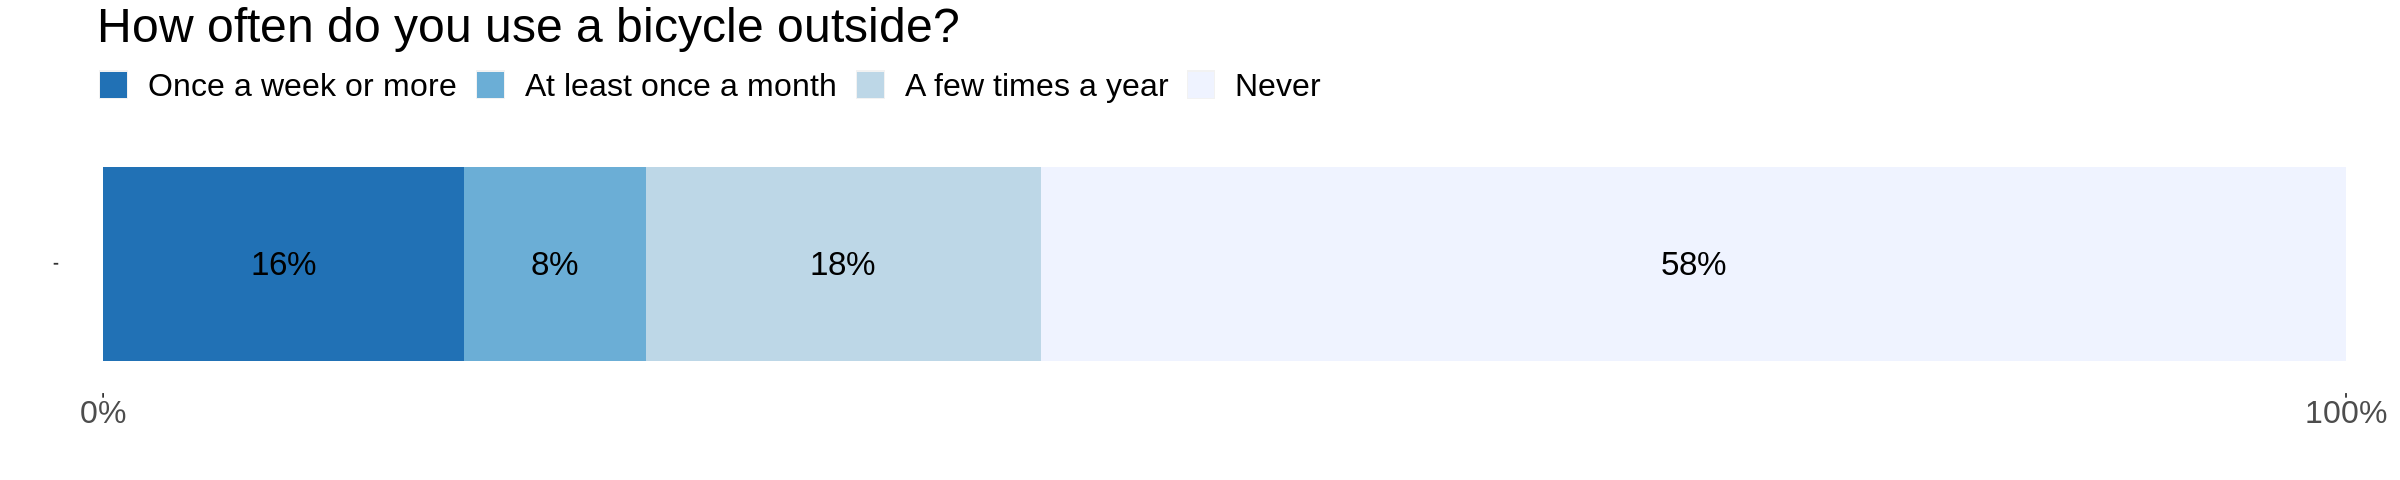

In [ ]:
dfPerson %>%
  # Filter out rows where person_weight is 0 or less and exclude 'Missing response' for bike frequency
  filter(person_weight > 0 & !bikefreq_f == "Missing response") %>%
  # Create a new factor variable by collapsing the bike frequency categories
  mutate(
    bikefreq_f2 = fct_collapse(
      bikefreq_f,
      "Once a week or more" = c("5 or more days a week", "4 days a week", "2-3 days a week", "1 day a week"),
      "At least once a month" = c("1-3 days a month"),
      "A few times a year" = "Less than monthly",
      "Never" = "Never"
    )
  ) %>%
  # Group the data by the new bike frequency factor
  group_by(bikefreq_f2) %>%
  # Summarize the data by calculating the sum of person_weight for each bike frequency group
  summarize(weighted_sum = sum(person_weight, na.rm = TRUE)) %>%
  # Calculate the proportion of each bike frequency group
  mutate(prop = weighted_sum / sum(weighted_sum)) %>%
  # Reverse the order of the new bike frequency factor levels
  mutate(bikefreq_f2 = forcats::fct_rev(bikefreq_f2)) %>%
  # Create a bar plot
  ggplot(aes(x = prop, y = "", fill = bikefreq_f2)) +
  geom_col() +  # Add bars
  geom_text(aes(label = scales::percent(prop, accuracy = 1)),  # Add percentages
            position = position_stack(vjust = 0.5),  # Center the text within the bars
            size = 7) +  # Set text size
  labs(x = "", y = "", fill = " ",title="   How often do you use a bicycle outside?") +  # Add axis labels and legend title
  scale_x_continuous(labels = scales::percent,breaks = c(0,1),expand = c(0.02,0)) +  # Format x-axis labels as percentages
  theme(text = element_text(size = 24), legend.position = "top",legend.justification = "left", panel.background = element_blank()) +  # Customize text size and legend position
  guides(fill = guide_legend(reverse = TRUE)) +  # Reverse the order of the legend
  scale_fill_brewer(palette = "Blues")


# Frequent biking and gender

We can use the Person data to analyze the gender of those who biked at all, excluding those who chose "prefer not to answer" or "other" to ensure accurate analysis. It is crucial to exercise caution when working with portions of data and to thoroughly assess the data before drawing any conclusions. Always use engineering judgment or a similar expert perspective when cleaning the results to ensure accuracy and reliability.

Of those who biked at all (i.e., the bike frequency is not never or missing), 42% are women and 57% are men.

Of those who biked at least once a week (use the bike frequency variable as a filter),30% are women while 68% are men.


In [ ]:
# Those who biked at all
dfPerson %>%
  # Filter out rows where person_weight is 0 or less, exclude specific bike frequencies and genders
  filter(person_weight > 0 &
         !bikefreq_f %in% c("Never", "Missing response") &
         !gender_f %in% c("Prefer not to answer", "Other")) %>%
  # Group the data by gender factor
  group_by(gender_f) %>%
  # Summarize the data by calculating the count of individuals and the sum of person_weight
  summarize(
    count = n(),  # Count the number of individuals in each gender group
    weighted_sum = sum(person_weight, na.rm = TRUE)  # Calculate the sum of person_weight for each gender group, ignoring NA values
  ) %>%
  # Calculate the proportion and format it as a percentage
  mutate(prop = paste0(100 * round(weighted_sum / sum(weighted_sum), 3), "%"))  # Multiply by 100 and format as a percentage string

# Those who biked at least once a week
dfPerson %>%
  # Filter out rows where person_weight is 0 or less, exclude more specific bike frequencies and genders
  filter(person_weight > 0 &
         !bikefreq_f %in% c("Never", "Missing response", "Less than monthly", "1-3 days a month") &
         !gender_f %in% c("Prefer not to answer", "Other")) %>%
  # Group the data by gender factor
  group_by(gender_f) %>%
  # Summarize the data by calculating the count of individuals and the sum of person_weight
  summarize(
    count = n(),  # Count the number of individuals in each gender group
    weighted_sum = sum(person_weight, na.rm = TRUE)  # Calculate the sum of person_weight for each gender group, ignoring NA values
  ) %>%
  # Calculate the proportion and format it as a percentage
  mutate(prop = paste0(100 * round(weighted_sum / sum(weighted_sum), 3), "%"))  # Multiply by 100 and format as a percentage string


gender_f,count,weighted_sum,prop
<fct>,<int>,<dbl>,<chr>
Woman,543,1086108.694,42.1%
Man,608,1467715.572,56.9%
Non-binary,18,21598.771,0.8%
Prefer to self-describe,3,2843.995,0.1%


gender_f,count,weighted_sum,prop
<fct>,<int>,<dbl>,<chr>
Woman,144,289996.211,30%
Man,282,666252.272,69%
Non-binary,11,7066.027,0.7%
Prefer to self-describe,2,2754.205,0.3%


Looking at the trip data, we will join it with the Person data to analyze the gender of those who bike in a typical week. The results show 19% of trips being made by women versus 80% by men.


In [ ]:
# Trip mode share
dfTrip %>%
  # Filter out rows where seven-day trip weight is NA or 0
  filter(!is.na(trip_svnday_weight) & trip_svnday_weight > 0) %>%
  # Create a factor variable for mode type
  mutate(
    mode_type_nyc_f = factor(mode_type_nyc, levels = labs.mode$value, labels = labs.mode$label)
  ) %>%
  # Group the data by mode type factor
  group_by(mode_type_nyc_f) %>%
  # Summarize the data by calculating the sum of seven-day trip weight for each mode type
  summarize(
    weighted_sum = sum(trip_svnday_weight, na.rm = TRUE)  # Calculate the sum of trip_svnday_weight, ignoring NA values
  ) %>%
  # Calculate the proportion and format it as a percentage
  mutate(prop = paste0(100 * round(weighted_sum / sum(weighted_sum), 3), "%"))  # Multiply by 100 and format as a percentage string

# Bike trips by gender
dfTrip %>%
  # Filter out rows where seven-day trip weight is NA or 0
  filter(!is.na(trip_svnday_weight) & trip_svnday_weight > 0) %>%
  # Create a factor variable for mode type
  mutate(
    mode_type_nyc_f = factor(mode_type_nyc, levels = labs.mode$value, labels = labs.mode$label)
  ) %>%
  # Further filter to only include trips made by bike
  filter(mode_type_nyc_f == "Bike") %>%
  # Join with dfPerson data on person_id
  left_join(dfPerson, by = "person_id") %>%
  # Filter out specific gender responses
  filter(!gender_f %in% c("Prefer not to answer")) %>%
  # Group the data by gender factor
  group_by(gender_f) %>%
  # Summarize the data by calculating the count of individuals and the sum of seven-day trip weight
  summarize(
    n = n(),  # Count the number of individuals in each gender group
    weighted_sum = sum(trip_svnday_weight, na.rm = TRUE)  # Calculate the sum of seven-day trip weight for each gender group, ignoring NA values
  ) %>%
  # Calculate the proportion and format it as a percentage
  mutate(prop = percent(weighted_sum / sum(weighted_sum), accuracy = 0.1))  # Use scales::percent to format the proportion


mode_type_nyc_f,weighted_sum,prop
<fct>,<dbl>,<chr>
For-Hire Vehicle,115102.17,0.4%
For-Hire Vehicle TNC,486609.79,1.6%
Commuter Rail,172551.40,0.6%
Bus,1317968.77,4.2%
Ferry,94598.93,0.3%
Subway,3739275.44,11.9%
Vehicle,10205123.30,32.6%
Bike,887558.63,2.8%
Walk,13990634.97,44.6%


gender_f,n,weighted_sum,prop
<fct>,<int>,<dbl>,<chr>
Woman,550,163242.7862,18.9%
Man,1170,694640.6052,80.2%
Non-binary,31,1596.4233,0.2%
Prefer to self-describe,15,842.2525,0.1%
Other,4,5275.5302,0.6%
